In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

import plotly.express as px
import plotly.graph_objects as go

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from custom_scripts.config import loader
from custom_scripts.evaluate_performance import evaluate_performance
from custom_scripts.prepare_data import prepare_data

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

### Input Parameters

Specificy: 

1. Which _Day of Week_ to use for data ('Tuesday' or 'Wednesday')
2. _Model_ to make predictions ('isf' for Isolation Forest, 'svm' for One-Class SVM, 'cov' for Elliptic Envelope or 'lof' for Local Outlier Factor.
3. Which day of the week the _Model trained on_ to make predictions
4. _Dimensions_ for PCA preprocessing (integer number, suggested value = 28)
5. Whether or not to use the model for _prediction_ or load existing predictions
6. What _fraction_ of the dataset to use in visualizations in this notebook

In [2]:
day_of_week = 'Tuesday'

model = 'svm'

model_trained_on='Wednesday'

new_dimension = 28 #Choose the number of features for PCA

fraction = 0.1 

### Load the data

In [3]:
data_file= loader(day_of_week=day_of_week,data_type='processed',subtype='Normalized')
df=pd.read_pickle(data_file)

## Preparing the Dataset for Anomaly Detection 

Here we need to separate our class variable, which in our case is "Label" from the rest of the dataset.

Anomaly detection algorithms output +1 for inlier and -1 for outliers. Therefore:

1. We need to map multiple classes to binary classes.
2. Since we are interesting in detecting anomalies, the negative class is 'BENIGN'.

In [25]:
X,y=prepare_data(data=df,class_column='Label',classes='binary',neg_class='BENIGN')

The class label vector has the following mapping structure:

- 1: Attack
- 0: Benign

### Subset: Dimensionality Reduction w/ PCA

We first implement PCA on the dataset to reduce the number of features. The number of features is informed by the feature ranking provided by the xgboost models trained on the dataset.

In [26]:
pca_model = PCA(n_components=new_dimension, random_state=4162)
pca_model.fit(X)
x_red_pca = pca_model.transform(X)

### Predict or Load Anomalies

Predict method returns 1 for inlier and -1 for outlier (aka anomalies)

First the code will try to load existing predictions. 

If such predictions do not exist, the code will try to load the model that can make such predictions and save the predictions for future use.

If neither predictions nor the model exists, it will raise an error.

These are transformed into:
- 1: Anomaly
- 0: Normal

In [27]:
try:
    print('Loading predictions...')
    filename='./predictions/'+model+'_anomalies_'+model_trained_on+'_data_'+day_of_week+'_PCA_'+str(new_dimension)+'.pkl'
    with open(filename,'rb') as file:
        anomalies=pickle.load(file)
    print('Predictions loaded!')
except:
    filename='./models/'+model+'_model_'+model_trained_on+'_PCA_'+str(new_dimension)+'.pkl'
    with open(filename,'rb') as file:
        anomaly_model=pickle.load(file)
    
    print('Making predictions...')
    anomalies = anomaly_model.predict(x_red_pca)
    
    filename_2 = './predictions/'+model+'_anomalies_'+model_trained_on+'_data_'+day_of_week+'_PCA_'+str(new_dimension)+'.pkl' 
    with open(filename_2,'wb') as file:
        pickle.dump(anomalies,file)   
    print('Predictions made! Also saved for future reference.')
        
anomalies = (anomalies*-1 +1)*0.5
anomalies = anomalies.astype(int)

Loading predictions...
Predictions loaded!


### Performance measures

We choose to investigate the performance using 

1. Confusion Matrix (full picture of anomaly classification)
2. Accuracy
3. Precision of the anomaly class
4. Recall on the anomaly class
5. F-1 Measure on the anomaly class
6. AUC score

In [28]:
confusion_matrix(y,anomalies,labels=[1,0])

array([[ 13832,      0],
       [431813,      0]], dtype=int64)

In [29]:
evaluate_performance(y,anomalies,dec_digits=10,pos_label=1)

Accuracy: 0.0310381582
Precision: 0.0310381582
Recall: 1.0
f-1 score: 0.0602075838
AUC score: 0.5


### Visualize detected anomalies

Load the t-SNE transformed data in 2-D for visualization if not already loaded.

In [122]:
data_size = x_red_pca.shape[0]

try:
    _ = np.shape(x_vis)
except NameError:
    filename='./tsne_transforms/'+day_of_week+'_perplexity_30_data_'+str(data_size)+'.pkl'
    with open(filename,'rb') as file:
        x_vis=pickle.load(file)

Plot the detected anomalies in the t-SNE transformed 2-D representation of the data.

In [123]:
sample_size = int(x_vis.shape[0]*fraction)

index = np.random.randint(0,x_vis.shape[0],sample_size)

x_red_vis = x_vis[index,:]

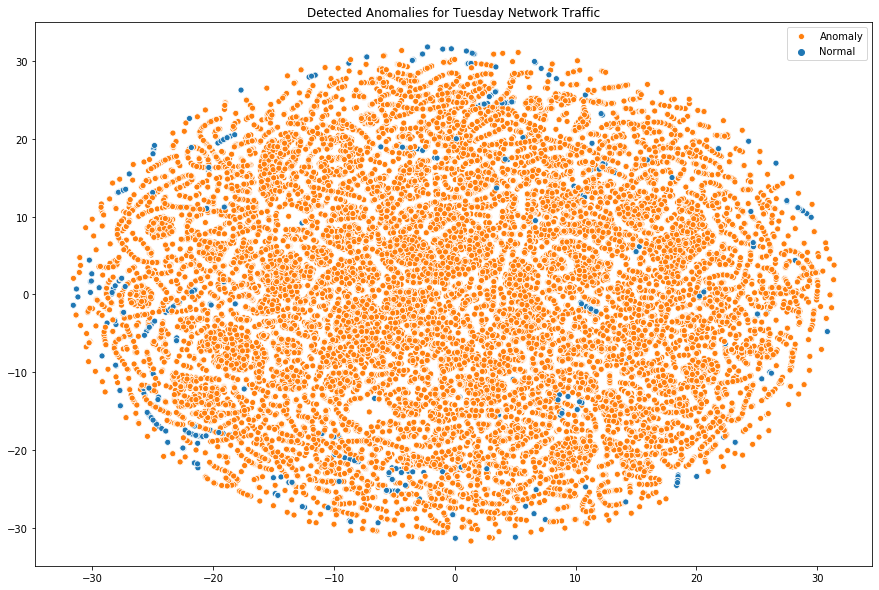

In [124]:
fig1=plt.figure(figsize=(15,10))
sns.scatterplot(x_red_vis[:,0],x_red_vis[:,1],hue=anomalies[index],hue_order=[1,0])
plt.title('Detected Anomalies for '+day_of_week+' Network Traffic')
plt.legend(['Anomaly','Normal'])
plt.show()

Plot the actual attacks on the network in the t-SNE transformed 2-D representation of the data.

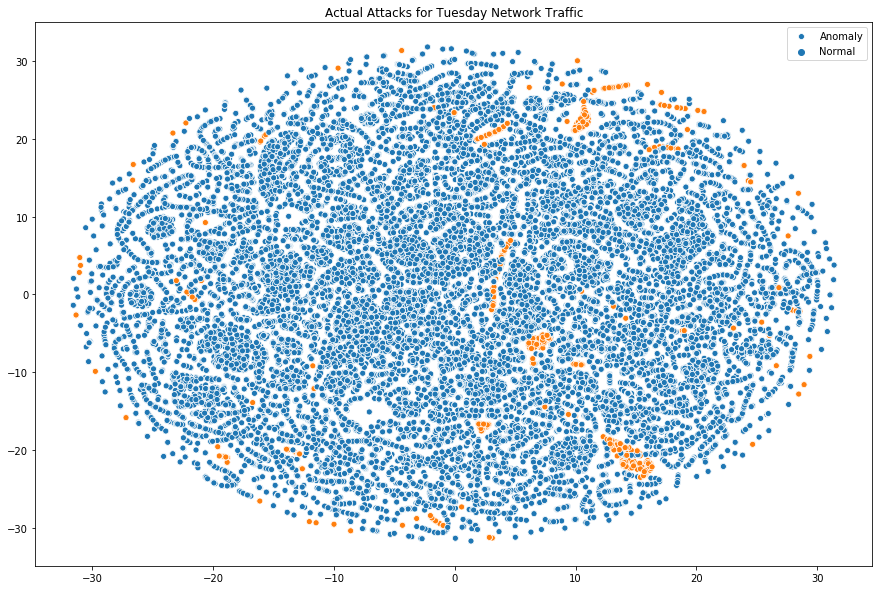

In [125]:
fig=plt.figure(figsize=(15,10))
sns.scatterplot(x_red_vis[:,0],x_red_vis[:,1],hue=y[index],hue_order=[0,1])
plt.title('Actual Attacks for '+day_of_week+' Network Traffic')
plt.legend(['Anomaly','Normal'])
plt.show()

### Prepare a data frame for the plotly interactive scatter plot.

In [59]:
x_plotly = pd.DataFrame(x_red_vis,columns=['dim1','dim2'])
x_plotly['anomaly']=anomalies[index]
anomaly_dict={0:'Anomaly',1:'Normal'}
x_plotly['Label']=x_plotly['anomaly'].map(anomaly_dict)

In [64]:
x_plotly['Label'].unique()

array(['Anomaly', 'Normal'], dtype=object)

### Plot.ly Interactive Visual

In [76]:
fig = px.scatter(x_plotly, 
                 x="dim1",
                 y='dim2',
                 color='Label',
                 color_discrete_map={'Anomaly':'orangered','Normal':'blue'},
                 hover_data=['Label'],
                 labels={'dim1':'','dim2':''},
                 title='Anomaly Detection Results for '+day_of_week+' Network Traffic ('+str(sample_size)+' data points)',
                 render_mode='webgl',
                 height=600
                )
fig.show()